In [ ]:
import os
import gc
from glob import glob
import warnings
import random
import easydict
import copy
from collections import defaultdict
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import itertools
# from sklearn.metrics import roc_auc_scorez
from PIL import Image

import os
# os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__() # openCV 최대 픽셀 오류 관리 코드
os.environ['OPENCV_IO_MAX_IMAGE_PIXELS'] = str(2**64)

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torchvision.transforms.functional import to_pil_image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import timm
import libtiff
from tqdm import tqdm

warnings.filterwarnings(action='ignore')
# libtiff.libtiff_ctypes.suppress_warnings()
gc.collect()
torch.cuda.empty_cache()
matplotlib.rcParams.update({'font.size': 14})
plt.rcParams['axes.unicode_minus'] = False
print('library import')

NameError: name 'timm' is not defined

In [17]:
# !pip install pylibtiff
# !pip install -U scikit-learn
# !pip install --upgrade scikit-learn


In [18]:
def seed_everything(random_seed: int):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    print('seed setting complete')

# hyperparams

In [19]:
##### HYPER PARAMETER

SEED = 42
PATCH_SIZE = (512, 512) # width, height
OVERLAP_RATIO = 0.1 #0.5
TISSUE_AREA_RATIO = 0.5
DROP_RATE = 0.5
EPOCH = 10
LEARNING_RATE = 3e-5
WEIGHT_DECAY = 1e-5

TRAIN_BATCH_SIZE = 64 #64
EVAL_BATCH_SIZE = 64 #256
TOPK = 5 # MIL top K

GPU_IDX = 'cuda'
DATE = '240102'

EXP_NAME = f'MAIC_{DATE}_{LEARNING_RATE}'
seed_everything(SEED)

seed setting complete


In [20]:
tissue_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

def is_inside_tissue(_mask):
    tissue_area = np.sum(_mask) // 255
    mask_area = np.prod(PATCH_SIZE)
    return (tissue_area / mask_area) > TISSUE_AREA_RATIO

def get_otsu_mask(_img):
    v = cv2.cvtColor(_img, cv2.COLOR_RGB2GRAY)
    v = cv2.medianBlur(v, 15)
    _, timg_th = cv2.threshold(v, -1, 255, cv2.THRESH_OTSU)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_OPEN, tissue_kernel, iterations=2)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_CLOSE, tissue_kernel, iterations=2)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_OPEN, tissue_kernel, iterations=5)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_CLOSE, tissue_kernel, iterations=5)
    return ~timg_th

def get_augmentation():
    _transform = [
        A.Rotate(),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.ColorJitter(),
    ]
    return A.Compose(_transform)

def get_preprocessing():
    _transform = [
        A.Resize(PATCH_SIZE[1], PATCH_SIZE[0]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # 새로운 nomalize도입 필요.
        ToTensorV2()
    ]
    return A.Compose(_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512)


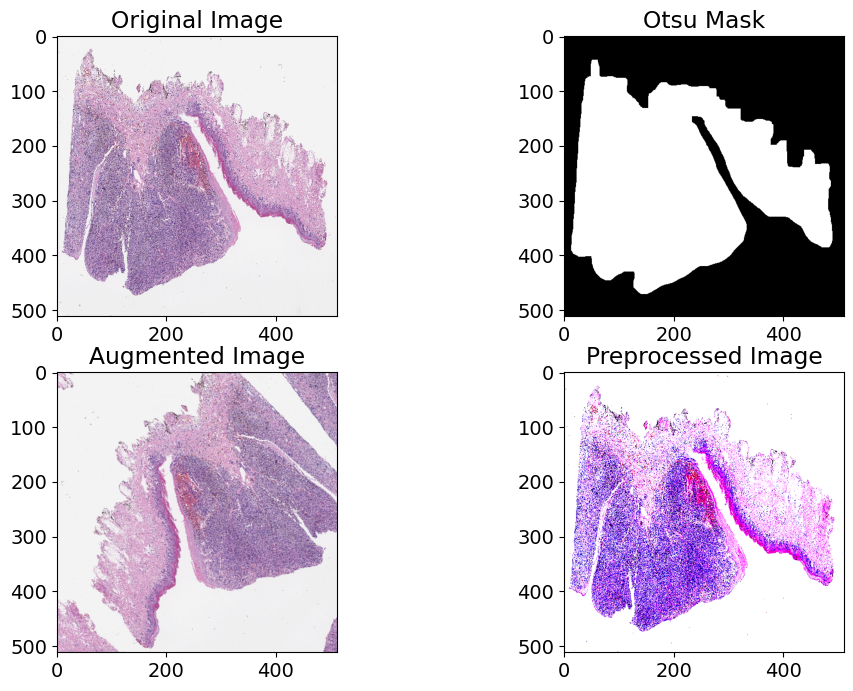

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 이전에 정의한 함수들 (is_inside_tissue, get_otsu_mask, get_augmentation, get_preprocessing)
sample_path = '../dataset/train/train_001.png'
# 샘플 이미지 로드
img = cv2.imread(sample_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV는 이미지를 BGR로 로드합니다
img = cv2.resize(img, (512, 512))
# Otsu 마스크 적용
otsu_mask = get_otsu_mask(img)
print(otsu_mask.shape)
# 데이터 증강 적용
augmented_img = get_augmentation()(image=img)['image']

# 전처리 적용
preprocessed_img = get_preprocessing()(image=img)['image']

# 시각화
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(2, 2, 2)
plt.imshow(otsu_mask, cmap='gray') # 512,512
plt.title('Otsu Mask')

plt.subplot(2, 2, 3)
plt.imshow(augmented_img) # 512,512,3
plt.title('Augmented Image')

plt.subplot(2, 2, 4)
plt.imshow(np.transpose(preprocessed_img.numpy(), (1, 2, 0))) #torch.Size([3, 512, 512]) totensor때문.
plt.title('Preprocessed Image')

plt.show()


# Dataset
## train valid test split & save pickle


In [51]:
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import time
import io


def split_dataset(slide_list, label_list, train_size=0.6, valid_size=0.2, test_size=0.2):
    """
    전체 슬라이드 리스트와 라벨 리스트를 받아 훈련, 검증, 테스트 세트로 분할합니다.
    """
    # 훈련 세트와 나머지를 분할
    train_slides, temp_slides, train_labels, temp_labels = train_test_split(
        slide_list, label_list, train_size=train_size, random_state=42, stratify=label_list)

    # 나머지를 검증과 테스트 세트로 분할
    valid_size_adjusted = valid_size / (valid_size + test_size)
    valid_slides, test_slides, valid_labels, test_labels = train_test_split(
        temp_slides, temp_labels, train_size=valid_size_adjusted, random_state=42, stratify=temp_labels)

    return (train_slides, train_labels), (valid_slides, valid_labels), (test_slides, test_labels)

class MILDataset(Dataset): # 참고 https://github.com/MSKCC-Computational-Pathology/MIL-nature-medicine-2019/blob/master/MIL_train.py
    def __init__(self, slide_list, label_list, augmentation=False, preprocessing=False):
        self.slide_list = slide_list # 받는 슬라이드 이미지 이름. ex) train_001.png
        self.label_list = label_list # 받는 슬라이드 이미지의 재발 여부 라벨.
        self.augmentation = get_augmentation() if augmentation else None # 어그멘테이션 적용.
        self.preprocessing = get_preprocessing() if preprocessing else None # 전처리 적용
        
        patch_list = [] 
        slide_idx = []
        for idx, slide_name in enumerate(tqdm(self.slide_list)):
            slide_path = f'../dataset/train/{slide_name}.png'
            
            try:
                img = cv2.imread(slide_path) # 하나의 슬라이드 이미지 오픈.
            except:
                print('Over size!!!',slide_path)
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # shape : (12965, 27888, 3)

            
            ### addition !!
            # img = cv2.resize(img, (1024, 1024), interpolation=cv2.INTER_AREA)
            ### addition !!
            
            
            tissue_mask = get_otsu_mask(img)
            h_, w_, _ = img.shape
            
            finded_patch = []
            for i in range(0, h_, int(PATCH_SIZE[1] * (1-OVERLAP_RATIO))):
                if i+PATCH_SIZE[1] > h_:
                    continue
                for j in range(0, w_, int(PATCH_SIZE[0] * (1-OVERLAP_RATIO))):
                    if j+PATCH_SIZE[0] > w_:
                        continue

                    patch_mask = tissue_mask[i:i+PATCH_SIZE[1], j:j+PATCH_SIZE[0]]
                    if not is_inside_tissue(patch_mask):
                        del patch_mask
                        gc.collect()
                        continue
                    
                    patch = img[i:i+PATCH_SIZE[1], j:j+PATCH_SIZE[0], :]
                    finded_patch.append(patch)
                    
            patch_list.extend(finded_patch)
            slide_idx.extend([idx] * len(finded_patch))
        
        self.patch_list = patch_list
        self.slide_idx = slide_idx
    
    def set_mode(self, mode):
        self.mode = mode
    
    def make_topk_data(self, idxs):
        self.t_data = [(self.slide_idx[idx], self.patch_list[idx], self.label_list[self.slide_idx[idx]]) for idx in idxs]
    
    def shuffle_topk_data(self):
        self.t_data = random.sample(self.t_data, len(self.t_data))


    def __getitem__(self, idx):
        if self.mode == 1: # eval
            slide_idx = self.slide_idx[idx]
            img = self.patch_list[idx]
            if self.preprocessing:
                    sample = self.preprocessing(image=img)
                    img = sample['image']
            label = self.label_list[slide_idx]
            return img, label, self.slide_list
        
        elif self.mode == 2: # train
            slide_idx, img, label = self.t_data[idx]
            if self.augmentation:
                    sample = self.augmentation(image=img)
                    img = sample['image']
            if self.preprocessing:
                    sample = self.preprocessing(image=img)
                    img = sample['image']
            return img, label
    
    def __len__(self):
        if self.mode == 1:
            return len(self.patch_list)
        elif self.mode == 2:
            return len(self.t_data)
        
# if __name__ == "__main__":
#     train_data = MILDataset(train_list, train_label, augmentation=True, preprocessing=True)
#     train_data.set_mode(mode=1)
#     train_dataloader = DataLoader(train_data, batch_size=EVAL_BATCH_SIZE, shuffle=False, num_workers=0)
#     train_train_dataloader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=False, num_workers=0)
#     for x,y in train_train_dataloader:
#         print(x.shape,y)
#         break

        # 사용 예시

def save_dataset_as_pickle(dataset, file_name):
    """
    데이터셋을 .pkl 파일 형식으로 저장합니다.
    """
    with open(file_name, 'wb') as f:
        pickle.dump(dataset, f)
        
if __name__ == "__main__":
    df = pd.read_csv('../dataset/train_dataset.csv')
    train_list = df['Slide_name'].tolist()
    train_label = df['Recurrence'].tolist()
    
    # train_list = [train_list[0],train_list[-1]]
    # train_label = [train_label[0],train_label[-1]]

    # toy set 10개 비재발 + 10개 재발 이미지
    # train_list = train_list[:10]+train_list[-10:]
    # train_label = train_label[:10]+train_label[-10:]
    
    
    # 전체 데이터 이미지 별로 pickle만들기
    for name,label in zip(train_list,train_label):
        print(name,label)
        train_data = MILDataset([name],[label], augmentation=None, preprocessing=True)
        train_data.set_mode(mode=1)
        save_dataset_as_pickle(train_data, f'../image_pickle/dataset_{name}.pkl')

 
    # 데이터셋 분할
    # train_set, valid_set, test_set = split_dataset(train_list, train_label)
    # print(train_set, valid_set, test_set)
    
    
    """    
    time1 = time.time()
    # train_set pickle 저장

    train_data = MILDataset(train_set[0], train_set[1], augmentation=None, preprocessing=True)
    train_data.set_mode(mode=1)
    time2 = time.time()
    
    save_dataset_as_pickle(train_data, 'train_dataset.pkl')

    time3 = time.time()
    print('trainset 만드는데 걸리는시간 :',time2-time1,'trainset 저장하는데 걸리는시간 :',time3-time2)
    
    # valid_set pickle 저장
    time1 = time.time()
    train_data = MILDataset(valid_set[0], valid_set[1], augmentation=None, preprocessing=True)
    train_data.set_mode(mode=1)
    time2 = time.time()
    save_dataset_as_pickle(train_data, 'valid_dataset.pkl')
    time3 = time.time()
    print('validset 만드는데 걸리는시간 :',time2-time1,'validset 저장하는데 걸리는시간 :',time3-time2)

    # test_set pickle 저장
    time1 = time.time()
    train_data = MILDataset(test_set[0], test_set[1], augmentation=None, preprocessing=True)
    train_data.set_mode(mode=1)
    time2 = time.time()
    save_dataset_as_pickle(train_data, 'test_dataset.pkl')
    time3 = time.time()
    print('testset 만드는데 걸리는시간 :',time2-time1,'testset 저장하는데 걸리는시간 :',time3-time2)
    """        
    # 각 데이터셋을 .npy 파일로 저장
    # np.save('train_dataset', train_data)
    # npy load
    # data_ex = np.load('train_dataset.npy', allow_pickle=True)

train_001 0


100% 1/1 [01:53<00:00, 113.61s/it]


train_885 1


100% 1/1 [05:01<00:00, 301.84s/it]


## load pickle

In [50]:
import pickle

def load_dataset_from_pickle(file_name):
    """
    .pkl 파일로부터 데이터셋을 로드합니다.
    
    :param file_name: 로드할 .pkl 파일의 이름
    :return: 파일에서 로드된 데이터셋
    """
    with open(file_name, 'rb') as file:
        dataset = pickle.load(file)
    return dataset

# 사용 예시
train_data = load_dataset_from_pickle('dataset_train_001.pkl')
print('get pickle')
i=333
len(train_data),train_data[i][0].shape,train_data[i][1],train_data[i][2]

get pickle


(791, torch.Size([3, 512, 512]), 0, ['train_001'])

In [9]:
### dataset 구조 파악 

# patch_list=[]
# slide_idx =[]
# slide_name = 'train_001'
# slide_path = f'../dataset/train/{slide_name}.png'
# img = cv2.imread(slide_path) # 하나의 슬라이드 이미지 오픈.
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 
# # img.shape 
# # (12965, 27888, 3)

# tissue_mask = get_otsu_mask(img)
# h_, w_, _ = img.shape

# finded_patch = []            
# for i in tqdm(range(0, h_, int(PATCH_SIZE[1] * (1-OVERLAP_RATIO)))):
#     if i+PATCH_SIZE[1] > h_:
#         continue # 다음 for문으로 들어감.
#     for j in range(0, w_, int(PATCH_SIZE[0] * (1-OVERLAP_RATIO))):
#         if j+PATCH_SIZE[0] > w_:
#             continue # 다음 for문으로 들어감

#         patch_mask = tissue_mask[i:i+PATCH_SIZE[1], j:j+PATCH_SIZE[0]]
#         if not is_inside_tissue(patch_mask):
#             del patch_mask #patch_mask 객체(현재 패치에 대한 마스크)를 메모리에서 삭제 
#             gc.collect() # 가비지 컬렉터 호출 : 더 이상 사용되지 않는 메모리를 해제하는 역할
#             # del을 사용하여 객체를 삭제한 후, gc.collect()를 호출함으로써, 
#             # 삭제된 객체가 차지하던 메모리가 실제로 해제되도록 하는 것. 이는 메모리 사용 효율성을 높이기 위한 코드
#             continue

#         patch = img[i:i+PATCH_SIZE[1], j:j+PATCH_SIZE[0], :]
#         finded_patch.append(patch)

# patch_list.extend(finded_patch)

In [10]:
def model_inference(dataloader, model):
    model.eval()
    probs = torch.FloatTensor(len(dataloader.dataset))
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(tqdm(dataloader)):
            data = data.to(GPU_IDX)
            output = model(data)
            prob = F.softmax(output, dim=-1)
            probs[batch_idx*EVAL_BATCH_SIZE:batch_idx*EVAL_BATCH_SIZE+data.size(0)] = prob.detach().cpu()[:, 1].clone()
    gc.collect()
    torch.cuda.empty_cache()
    return probs.numpy()

def model_train(dataloader, model, criterion, optimizer):
    train_loss_list = []
    train_label_list = []
    train_prob_list = []
    model.train()
    for batch_idx, (data, label) in enumerate(dataloader):
        data = data.to(GPU_IDX)
        label = label.to(GPU_IDX)
        output = model(data)
        optimizer.zero_grad()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())
        train_label_list.extend(label.detach().cpu().numpy())
        train_prob_list.extend(F.softmax(output, dim=-1).detach().cpu().numpy()[:, 1])
    gc.collect()
    torch.cuda.empty_cache()
    return train_loss_list, train_label_list, train_prob_list

def group_argtopk(groups, data,k=1):
    order = np.lexsort((data, groups))
    groups = groups[order]
    data = data[order]
    index = np.empty(len(groups), 'bool')
    index[-k:] = True
    index[:-k] = groups[k:] != groups[:-k]
    return list(order[index])

In [11]:
# df = pd.read_csv('../dataset/train_dataset.csv')
# train_list = df['Slide_name'].tolist()
# train_label = df['Recurrence'].tolist()


# train_list = [train_list[0],train_list[-10]]
# train_label = [train_label[0],train_label[-10]]
# print(train_list,train_label)


# probs = torch.FloatTensor(len(train_dataloader.dataset))
# with torch.no_grad():
#     for batch_idx, (data, label) in enumerate(tqdm(train_dataloader)):
#         data = data.to(GPU_IDX)
#         output = model(data)
#         prob = F.softmax(output, dim=-1)
#         probs[batch_idx*EVAL_BATCH_SIZE:batch_idx*EVAL_BATCH_SIZE+data.size(0)] = prob.detach().cpu()[:, 1].clone()
# gc.collect()
# torch.cuda.empty_cache()

# print(probs)

In [12]:
# train_data = MILDataset(train_list, train_label, augmentation=True, preprocessing=True)
# train_data.set_mode(mode=1)
# train_dataloader = DataLoader(train_data, batch_size=EVAL_BATCH_SIZE, shuffle=False, num_workers=0)
# train_train_dataloader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=False, num_workers=0)

In [13]:
model = timm.create_model('resnet50', pretrained=True, num_classes=2, drop_rate=DROP_RATE)
model = model.to(GPU_IDX)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [14]:
# x1 = torch.tensor([1])
# x1 = x1.to('cuda')
# x1.is_cuda

# model test

dummy_x = torch.randn(4,3,512,512)
dummy_x = dummy_x.to(GPU_IDX)
dummy_y = model(dummy_x)

print(dummy_y.shape)

torch.Size([4, 2])


# roc auc score 

In [2]:
# error fix
# print(type(log_df))

import numpy as np
from sklearn.metrics import auc
import numpy as np

def roc_auc_score(y_true, y_scores):
    # NumPy 배열로 변환하고 1차원을 확인합니다.
    y_true = np.asarray(y_true).ravel()
    y_scores = np.asarray(y_scores).ravel()

    # 정렬된 점수와 해당하는 라벨을 얻습니다
    sorted_indices = np.argsort(y_scores)[::-1]
    sorted_scores = y_scores[sorted_indices]
    sorted_true = y_true[sorted_indices]

    # 누적 긍정 개수와 부정 개수
    cum_positive = np.cumsum(sorted_true == 1)
    cum_negative = np.cumsum(sorted_true == 0)

    # TPR과 FPR 계산
    tpr = cum_positive / np.sum(y_true == 1)
    fpr = cum_negative / np.sum(y_true == 0)

    # 초기값 추가 (FPR이 0일 때 TPR)
    tpr = np.append([0], tpr)
    fpr = np.append([0], fpr)

    # 트래프로이드 규칙을 사용하여 AUC 계산
    roc_auc = np.trapz(tpr, fpr)

    return roc_auc
list1 = [0,0,0,1,1,1,1,1]
roc_auc_score(list1, [0 for _ in range(len(list1)])


1.0

In [16]:
# schedular
import math
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts , CyclicLR, ExponentialLR,StepLR, CosineAnnealingLR

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

# train

In [17]:
LR = 5e-6
lr_max = 7e-5

optimizer = torch.optim.Adam(model.parameters(),lr = LR)#, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
# criterion = nn.BCELoss()

# 여러 scheduler 사용
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=7, T_mult=1, eta_max=lr_max,  T_up=3, gamma=0.9)
EPOCH = 20
# TRAIN_BATCH_SIZE = 16
for epoch in tqdm(range(EPOCH)):
    print(f'Epoch {epoch}')
    train_data = load_dataset_from_pickle('../pickle/train_dataset.pkl')
    train_train_dataloader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=0)
    train_loss_list, train_label_list, train_prob_list = model_train(train_train_dataloader, model, criterion, optimizer)
    train_loss = np.mean(train_loss_list)
    print(train_loss)
    scheduler.step()

  0% 0/20 [00:00<?, ?it/s]

Epoch 0


  5% 1/20 [02:42<51:28, 162.54s/it]

0.6945812778039412
Epoch 1


 10% 2/20 [04:45<41:45, 139.20s/it]

0.6655617269602689
Epoch 2


 15% 3/20 [06:53<38:03, 134.35s/it]

0.49220587638291446
Epoch 3


 20% 4/20 [09:05<35:34, 133.40s/it]

0.1944384822791273
Epoch 4


 25% 5/20 [11:15<33:01, 132.13s/it]

0.0764047362249006
Epoch 5


 30% 6/20 [13:23<30:28, 130.57s/it]

0.051499938973310316
Epoch 6


 35% 7/20 [15:31<28:07, 129.84s/it]

0.03362845198505304
Epoch 7


 40% 8/20 [17:40<25:56, 129.67s/it]

0.03289019679650664
Epoch 8


 45% 9/20 [19:50<23:44, 129.54s/it]

0.031653128945353354
Epoch 9


 50% 10/20 [21:59<21:34, 129.48s/it]

0.024190080792389133
Epoch 10


 55% 11/20 [24:03<19:08, 127.63s/it]

0.017970709858292883
Epoch 11


 60% 12/20 [26:09<16:58, 127.32s/it]

0.015110537441532042
Epoch 12


 65% 13/20 [28:14<14:45, 126.43s/it]

0.009007723187096417
Epoch 13


 70% 14/20 [30:14<12:26, 124.49s/it]

0.008099621386182579
Epoch 14


 75% 15/20 [32:13<10:15, 123.08s/it]

0.007830863511613146
Epoch 15


 80% 16/20 [34:13<08:08, 122.06s/it]

0.00650774785740809
Epoch 16


 85% 17/20 [36:21<06:11, 123.69s/it]

0.005162124873392961
Epoch 17


 90% 18/20 [38:35<04:13, 127.00s/it]

0.005112865706376562
Epoch 18


 95% 19/20 [41:00<02:12, 132.49s/it]

0.004620474374281581
Epoch 19


100% 20/20 [43:27<00:00, 130.35s/it]

0.003969789617589082


In [30]:
# for batch_idx, (data, label) in enumerate(tqdm(train_train_dataloader)):
#     print(data.shape)
#     print(label)
#     break
import pickle

def load_dataset_from_pickle(file_name):
    """
    .pkl 파일로부터 데이터셋을 로드합니다.
    
    :param file_name: 로드할 .pkl 파일의 이름
    :return: 파일에서 로드된 데이터셋
    """
    with open(file_name, 'rb') as file:
        dataset = pickle.load(file)
    return dataset


# model inference:
train_data = load_dataset_from_pickle('../pickle/valid_dataset.pkl')
train_train_dataloader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=0)


model = torch.load('resnet50_20EP.pt')
model.eval()
label_list = []

probs = torch.FloatTensor(len(train_train_dataloader.dataset))
with torch.no_grad():
    for batch_idx, (data, label) in enumerate(tqdm(train_train_dataloader)):
        data = data.to(GPU_IDX)
        output = model(data)
        prob = F.softmax(output, dim=-1)
        probs[batch_idx*EVAL_BATCH_SIZE:batch_idx*EVAL_BATCH_SIZE+data.size(0)] = prob.detach().cpu()[:, 1].clone()
        label = label.numpy()
        label_list.extend(label)
gc.collect()
torch.cuda.empty_cache()
probs_list = probs.numpy()



###########
###########
###########

n = len(label_list)
print(n)

tp =0
tn =0
fp =0
fn =0

answer = 0
for target,predict in zip(label_list,probs_list):
    if predict>0.5:
        if target==1:
            tp+=1
        else:
            fp+=1
    else:
        if target==0:
            tn+=1
        else:
            fn+=1


100% 24/24 [00:45<00:00,  1.89s/it]

1478
0.0


In [36]:
# torch.save(model,'resnet50_20EP.pt')
print('accuracy      precision     recall')
(tp+tn)/n,tp/(tp+fp),tp/(tp+fn)

accuracy      precision     recall


(0.8843031123139378, 0.9803921568627451, 0.8168028004667445)

In [25]:
"""
seed_everything(SEED)

SAVE_PATH = f'./{EXP_NAME}/'
if os.path.isdir(SAVE_PATH):
    pass
else:
    os.mkdir(SAVE_PATH)

if not os.path.isfile(f'./{EXP_NAME}_log.csv'):
    log_df = pd.DataFrame(columns=['epoch', 'train_loss', 'train_auc'])
else:
    log_df = pd.read_csv(f'./{EXP_NAME}_log.csv')

log_train_loss = []
log_train_auc = []

EPOCH = 1

TRAIN_BATCH_SIZE = 16
for epoch in tqdm(range(EPOCH)):
    print(f'Epoch {epoch}')
    
    #################
    ##### train #####
    #################
    print('#################')
    print('##### train #####')
    print('#################')
    
    train_data = load_dataset_from_pickle('../pickle/valid_dataset.pkl')
    print('get pickle')

    # dataloader로 가져오기.
    # train_dataloader = DataLoader(train_data, batch_size=EVAL_BATCH_SIZE, shuffle=False, num_workers=0)
    
    # train_data.set_mode(mode=1)
    # train_probs = model_inference(train_dataloader, model)
    # train_topk = group_argtopk(np.array(train_data.slide_idx), train_probs, 1)#TOPK)
    # train_data.make_topk_data(train_topk)
    # train_data.shuffle_topk_data()
    # train_data.set_mode(mode=2)
    print('################')
    print('model train!!!')
    print('################')
    
    train_train_dataloader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=False, num_workers=0)
    train_loss_list, train_label_list, train_prob_list = model_train(train_train_dataloader, model, criterion, optimizer)
    train_loss = np.mean(train_loss_list)
    print(train_loss)
    train_auc = roc_auc_score(train_label_list, train_prob_list)
    print(f'Epoch [{epoch}/{EPOCH}], Step [{len(train_train_dataloader)}/{len(train_train_dataloader)}], Loss: {train_loss:.4f}, AUC: {train_auc:.4f}')
    log_train_loss.append(train_loss) #train_auc
    log_train_auc.append(train_auc)
    gc.collect()
    torch.cuda.empty_cache()
    
    # save model
    torch.save(model.state_dict(), f'{SAVE_PATH}{EXP_NAME}_epoch {epoch}.pth')
    
    log_df = log_df.append({'epoch': epoch, 'train_loss': train_loss, 'train_auc': train_auc}, ignore_index=True)
    log_df.to_csv(f'./{EXP_NAME}_log.csv', sep=',', index=None)
    
    plt.title('Loss')
    plt.plot(log_train_loss, label='train')
    plt.legend()
    plt.show()

    plt.title('AUC')
    plt.plot(log_train_auc, label='train')
    plt.legend()
    plt.show()
"""
print()

In [27]:
# print(dir(train_data))

# print(type(train_data))
# train_data.slide_idx,train_probs,TOPK

In [29]:
# data = train_probs
# groups = np.array(train_data.slide_idx)
# k = 1
# order = np.lexsort((data, groups))
# groups = groups[order]
# data = data[order]
# index = np.empty(len(groups), 'bool')
# index[-k:] = True
# index[:-k] = groups[k:] != groups[:-k]


# inference

In [32]:
class MILDataset(Dataset): # 참고 https://github.com/MSKCC-Computational-Pathology/MIL-nature-medicine-2019/blob/master/MIL_train.py
    def __init__(self, slide_list, augmentation=False, preprocessing=False):
        self.slide_list = slide_list
        self.augmentation = get_augmentation() if augmentation else None
        self.preprocessing = get_preprocessing() if preprocessing else None
        
        patch_list = []
        slide_idx = []
        for idx, slide_name in enumerate(tqdm(self.slide_list)):
            slide_path = f'../dataset/test_public/{slide_name}.png'

            # img = cv2.imread(slide_path)
             try:
                img = cv2.imread(slide_path) # 하나의 슬라이드 이미지 오픈.
            except:
                print('Over size!!!',slide_path)
                continue
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            tissue_mask = get_otsu_mask(img)
            h_, w_, _ = img.shape
            
            finded_patch = []            
            for i in range(0, h_, int(PATCH_SIZE[1] * (1-OVERLAP_RATIO))):
                if i+PATCH_SIZE[1] > h_:
                    continue
                for j in range(0, w_, int(PATCH_SIZE[0] * (1-OVERLAP_RATIO))):
                    if j+PATCH_SIZE[0] > w_:
                        continue

                    patch_mask = tissue_mask[i:i+PATCH_SIZE[1], j:j+PATCH_SIZE[0]]
                    if not is_inside_tissue(patch_mask):
                        del patch_mask
                        gc.collect()
                        continue
                    
                    patch = img[i:i+PATCH_SIZE[1], j:j+PATCH_SIZE[0], :]
                    finded_patch.append(patch)
                    
            patch_list.extend(finded_patch)
            slide_idx.extend([idx] * len(finded_patch))
        
        self.patch_list = patch_list
        self.slide_idx = slide_idx
    
    def set_mode(self, mode):
        self.mode = mode
    
    def make_topk_data(self, idxs):
        self.t_data = [(self.slide_idx[idx], self.patch_list[idx]) for idx in idxs]
    
    def shuffle_topk_data(self):
        self.t_data = random.sample(self.t_data, len(self.t_data))
    
    def __getitem__(self, idx):
        if self.mode == 1: # eval
            slide_idx = self.slide_idx[idx]
            img = self.patch_list[idx]
            if self.preprocessing:
                    sample = self.preprocessing(image=img)
                    img = sample['image']
            return img
        
        elif self.mode == 2: # train
            slide_idx, img = self.t_data[idx]
            if self.augmentation:
                    sample = self.augmentation(image=img)
                    img = sample['image']
            if self.preprocessing:
                    sample = self.preprocessing(image=img)
                    img = sample['image']
            return img
    
    def __len__(self):
        if self.mode == 1:
            return len(self.patch_list)
        elif self.mode == 2:
            return len(self.t_data)

if __name__ == "__main__":
    df = pd.read_csv('../dataset/train_dataset.csv')
    train_list = df['Slide_name'].tolist()
        # train_set pickle 저장
    time1 = time.time()
    train_data = MILDataset(
        [0], train_set[1], augmentation=None, preprocessing=True)
    train_data.set_mode(mode=1)
    time2 = time.time()
    
    save_dataset_as_pickle(train_data, 'train_dataset.pkl')

    time3 = time.time()
    print('set 만드는데 걸리는시간 :',time2-time1,'set 저장하는데 걸리는시간 :',time3-time2)

In [33]:
def model_inference(dataloader, model):
    model.eval()
    probs = torch.FloatTensor(len(dataloader.dataset))
    with torch.no_grad():
        for batch_idx, data in enumerate(tqdm(dataloader)):
            data = data.to(GPU_IDX)
            output = model(data)
            prob = F.softmax(output, dim=-1)
            probs[batch_idx*EVAL_BATCH_SIZE:batch_idx*EVAL_BATCH_SIZE+data.size(0)] = prob.detach().cpu()[:, 1].clone()
    gc.collect()
    torch.cuda.empty_cache()
    return probs.numpy()

def model_valid(dataloader, model):
    valid_prob_list = []
    model.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(tqdm(dataloader)):
            data = data.to(GPU_IDX)
            output = model(data)
            output = torch.mean(output, axis=0, keepdim=True)
            valid_prob_list.extend(F.softmax(output, dim=-1).detach().cpu().numpy()[:, 1])
    gc.collect()
    torch.cuda.empty_cache()
    return valid_prob_list

In [ ]:
test_df = pd.read_csv('../dataset/test_public_dataset.csv')

test_list = test_df['Slide_name'].tolist()

# test_list = [test_list[0],test_list[-1]]
test_data = MILDataset(test_list, augmentation=False, preprocessing=True)
test_data.set_mode(mode=1)
test_dataloader = DataLoader(test_data, batch_size=EVAL_BATCH_SIZE, shuffle=False, num_workers=0)
test_test_dataloader = DataLoader(test_data, batch_size=TOPK, shuffle=False, num_workers=0)

In [80]:
model = timm.create_model('resnet50', pretrained=True, num_classes=2, drop_rate=DROP_RATE)
model_path = f'{SAVE_PATH}{EXP_NAME}_epoch {epoch}.pth'
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model = model.to(GPU_IDX)

seed_everything(SEED)

#################
##### test  #####
#################
print('#################')
print('##### test  #####')
print('#################')
test_data.set_mode(mode=1)
test_probs = model_inference(test_dataloader, model)
test_topk = group_argtopk(np.array(test_data.slide_idx), test_probs, TOPK)
test_data.make_topk_data(test_topk)
test_data.set_mode(mode=2)    
test_prob_list = model_valid(test_test_dataloader, model)

plt.show()
gc.collect()
torch.cuda.empty_cache()

seed setting complete
#################
##### test  #####
#################


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [10]:
# submission_df

In [8]:
import copy
import pandas as pd
test_df = pd.read_csv('../dataset/test_public_dataset.csv')
submission_df = copy.deepcopy(test_df)
# submission_df['predict_proba'] = test_prob_list
submission_df['predict_proba'] = 1
submission_df = submission_df.groupby(['Patient_ID']).agg({'predict_proba': 'mean'}).reset_index()

In [11]:
submission_df.to_csv('./submission.csv', sep=',', index=None)

In [84]:
print(0)
curl --user "jhshinst@gmail.com:honneychip13!" -X POST -F "files=@submission.csv" https://maic.or.kr/api/direct-report/28? password=aPfnF7TsAuMYdwKd

0
